<a href="https://colab.research.google.com/github/Olofmeister007/Pytorch-Prac/blob/main/pytorch_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [19]:
from sklearn.datasets import make_circles

In [20]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [21]:
print(X.shape)
print(y.shape)
print(X[:5])
print(y[:5])

(1000, 2)
(1000,)
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [22]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2" : X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


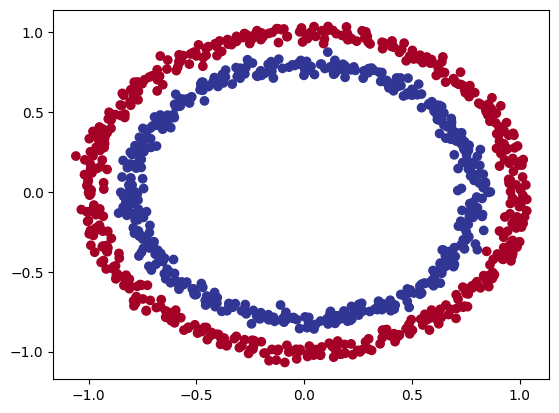

In [23]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [24]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [25]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)




In [26]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [27]:
from sklearn.model_selection import train_test_split


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20 % = test

In [29]:
import torch
from torch import nn


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,5)
    self.layer_2 = nn.Linear(5,1)


  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [31]:
model0 = CircleModelV0().to(device)

In [32]:
next(model0.parameters()).device

device(type='cpu')

In [33]:
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [34]:
with torch.inference_mode():
  untrained_preds = model0(X_test.to(device))


print(f"first ten preds {untrained_preds[:10]}")
print(f"first ten test labels {y_test[:10]}")

first ten preds tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])
first ten test labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [35]:
# for regression mse or mae
# for classification binary cross entropy or categorical cross entropy

# BCE(requires inputs to go through signmoid) and BCEWithlogits (sigmoid built in)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [36]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc
  #output = raw logits we can pass them to prediction probabilities by passing them through some activation function such as sigmoid then convert probabilityies to labels


In [37]:
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]
y_logits


tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [38]:
 y_pred_probs = torch.sigmoid(y_logits)
 y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [39]:
y_preds = torch.round(y_pred_probs) # y >= 0.5, y=1, class 1  y<0.5, y=0, class 0
y_preds

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [40]:
y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5])) # Removing the call to y_pred_probs and using sigmoid directly
print(torch.eq(y_pred_labels.squeeze(), y_preds.squeeze())) # Compare to y_preds

tensor([True, True, True, True, True])


In [41]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

In [43]:
epochs = 100

for epoch in range(epochs):
  model0.train()
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

 # loss = loss_fn(torch.sigmoid(y_logits), y_train) for BCELOSS

  loss = loss_fn(y_logits,y_train) #BCEWITHLOGITS Expects logits
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #testing
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test_loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69796 | Acc: 51.88 | Test_loss: 0.69440 | Test Acc: 58.00
Epoch: 10 | Loss: 0.69590 | Acc: 51.25 | Test_loss: 0.69305 | Test Acc: 53.00
Epoch: 20 | Loss: 0.69490 | Acc: 51.62 | Test_loss: 0.69254 | Test Acc: 49.50
Epoch: 30 | Loss: 0.69435 | Acc: 51.12 | Test_loss: 0.69236 | Test Acc: 49.50
Epoch: 40 | Loss: 0.69401 | Acc: 50.88 | Test_loss: 0.69232 | Test Acc: 51.00
Epoch: 50 | Loss: 0.69378 | Acc: 50.25 | Test_loss: 0.69234 | Test Acc: 50.00
Epoch: 60 | Loss: 0.69362 | Acc: 50.00 | Test_loss: 0.69239 | Test Acc: 51.50
Epoch: 70 | Loss: 0.69351 | Acc: 50.25 | Test_loss: 0.69246 | Test Acc: 51.00
Epoch: 80 | Loss: 0.69342 | Acc: 49.88 | Test_loss: 0.69254 | Test Acc: 50.00
Epoch: 90 | Loss: 0.69336 | Acc: 49.88 | Test_loss: 0.69262 | Test Acc: 53.00


In [44]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists


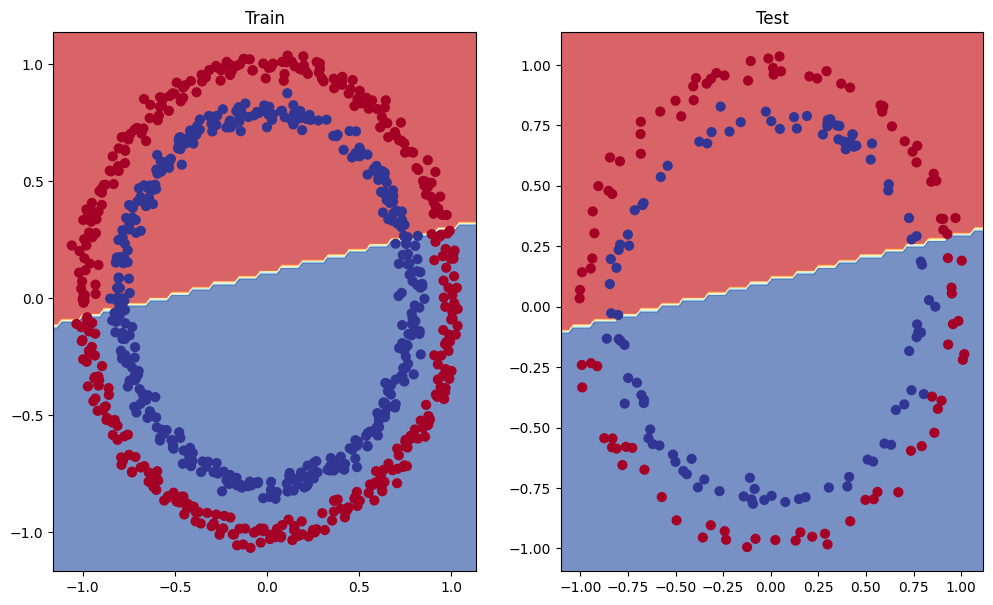

In [45]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

# LECTURE 77

In [46]:
#improving a model from model perspective (epochs , activations functions, add more layers, add more hidden units, change learning rate, change loss function)
class CircleModelv1(nn.Module) #logits usually represented as z
  def __init__(self): #we usually change one thing at a time to check what has the greatest impact on our model's perfomance
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    nn.Relu()
    self.layer_2 = nn.Linear(in_features=10, out_features=1) #not following this section from video cuz i already know it
    nn.Sigmoid()

SyntaxError: expected ':' (<ipython-input-46-31a1a4537aee>, line 2)

In [47]:
# testing the model with a smaller problem to see if there is something fundamentayll wrong with our model

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

In [48]:
train_split = int(0.8 * len(X_regression))
X_train_regression , y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [49]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2
 #we can use same architecture as model1 just change the input and output features according to our needs

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

In [52]:
for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)
  # acc = accuracy_fn()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():

    y_test_pred = model_2(X_test_regression)
    test_loss = loss_fn(y_test_pred, y_test_regression)
    # acc = accuracy_fn()

  if epoch % 100 == 0:
    print("EPOCH LOSS AND ACCURACY")


EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY
EPOCH LOSS AND ACCURACY


In [53]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

#From helper file imported form github
plot_predictions() #TODO

TypeError: plot_predictions() missing 4 required positional arguments: 'train_data', 'train_labels', 'test_data', and 'test_labels'

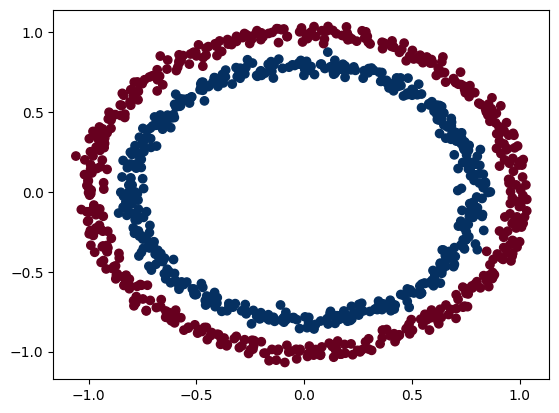

In [54]:
# we need to intorduce non-linearity because our data is non linearitiyy
# non linearity and lieanrity is very powerful beacuse with straight and non straight lines which in infinite in number we could basicallly make any prediction that we want
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03,random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);


In [55]:
import torch
from sklearn.model_selection import train_test_split

#Turn data into tensors

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)



In [92]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(2,10)
      self.layer_2 = nn.Linear(10, 10)
      self.layer_3 = nn.Linear(10, 1)
      # self.layer_4 = nn.Linear(10,1)
      self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3




CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [93]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.1)

In [94]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test_loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00 | Test_loss: 0.69394 | Test Acc: 50.00
Epoch: 100 | Loss: 0.00168 | Acc: 100.00 | Test_loss: 0.00744 | Test Acc: 100.00
Epoch: 200 | Loss: 0.00071 | Acc: 100.00 | Test_loss: 0.00543 | Test Acc: 100.00
Epoch: 300 | Loss: 0.00041 | Acc: 100.00 | Test_loss: 0.00493 | Test Acc: 100.00
Epoch: 400 | Loss: 0.00026 | Acc: 100.00 | Test_loss: 0.00573 | Test Acc: 100.00
Epoch: 500 | Loss: 0.00018 | Acc: 100.00 | Test_loss: 0.00516 | Test Acc: 100.00
Epoch: 600 | Loss: 0.00013 | Acc: 100.00 | Test_loss: 0.00513 | Test Acc: 100.00
Epoch: 700 | Loss: 0.00010 | Acc: 100.00 | Test_loss: 0.00534 | Test Acc: 100.00
Epoch: 800 | Loss: 0.00008 | Acc: 100.00 | Test_loss: 0.00560 | Test Acc: 100.00
Epoch: 900 | Loss: 0.00007 | Acc: 100.00 | Test_loss: 0.00577 | Test Acc: 100.00


In [95]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    y_preds = torch.round(torch.sigmoid(model_3(X_test).squeeze()))



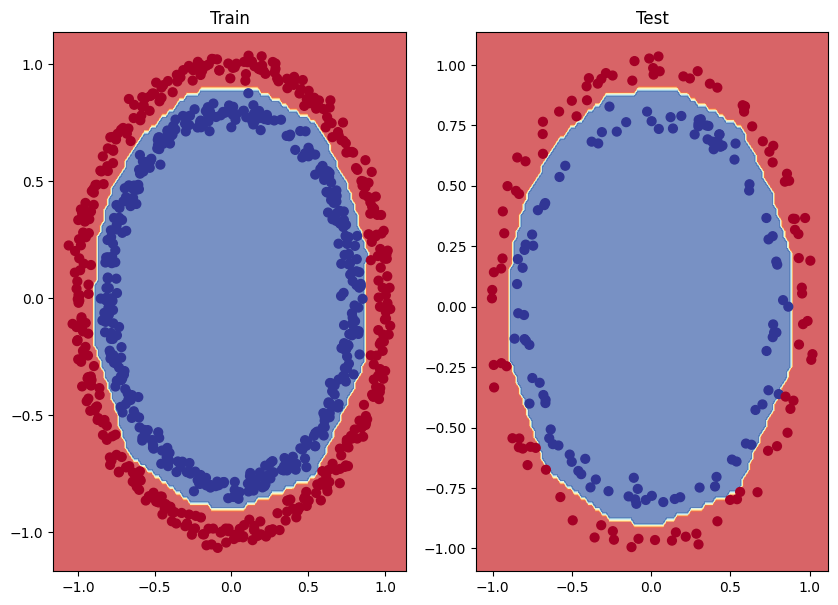

In [96]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


In [ ]:
#start from 86